# PlantVillage dataset

In [1]:
import torch.utils.data as data
import torchvision
from torchvision import transforms
import torch.optim as optim
import torch, time

import matplotlib.pyplot as plt
import numpy as np


# Transforms 

In [2]:
from torchvision import transforms as T

TRAIN_TRANSFORMERS = transforms.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(50),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # will help the model to work faster &
    #predi better by normalizing the data to -1, 0
    ])

VAL_TRANSFORMERS = transforms.Compose([
    T.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # will help the model to work faster &
    #predi better by normalizing the data to -1, 0
    ])


TEST_TRANSFORMERS = transforms.Compose([
    T.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # will help the model to work faster &
    #predi better by normalizing the data to -1, 0
    ])


# Train-Val-Test.... Split the PlantVillage dataset

In [3]:
# import splitfolders
# input_folder = './PlantVillage/'
# splitfolders.ratio(input_folder, output='./NewPlantVillageFolder', seed=24, ratio=(.7, .2, .1), group_prefix=None)

train_data = torchvision.datasets.ImageFolder(root='./NewPlantVillageFolder/train/', transform=TRAIN_TRANSFORMERS)
val_data = torchvision.datasets.ImageFolder(root='./NewPlantVillageFolder/val/', transform=VAL_TRANSFORMERS)
tes_data = torchvision.datasets.ImageFolder(root='./NewPlantVillageFolder/test/', transform=TEST_TRANSFORMERS)


## In our train_data_loader dataset we have ( 701, 701, 106 ) which is unbalanced ....

In [4]:

train_data_loader = data.DataLoader(train_data, shuffle=True, batch_size=32, num_workers=4)
#we're doubling it by 2 on the val_ data_loader cuz we're not goint to calculate the grediant, 
# so we do not use as much as mimory as the train_data_loader
val_data_loader  = data.DataLoader(val_data, shuffle=False, batch_size=64, num_workers=4) 
test_data_loader = data.DataLoader(tes_data, shuffle=False, batch_size=64, num_workers=4)

print(len(train_data))
print(len(val_data))
print(len(tes_data))

print('====================')

print(len(train_data_loader))
print(len(val_data_loader))
print(len(test_data_loader))

1506
430
216
48
7
4


In [5]:
images, labels = next(iter(train_data_loader))
images.shape

torch.Size([32, 3, 224, 224])

In [6]:
train_data.classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
train_data.class_to_idx

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

# show_transformed_images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([15, 3, 224, 224]) tensor([0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
labels >>  tensor([0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])


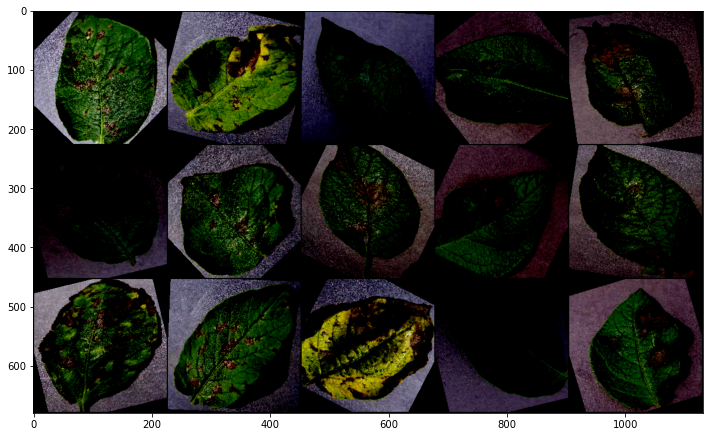

In [8]:
def show_transformed_images(dataset):
    loader = data.DataLoader(train_data, batch_size=15, shuffle=True)
    batch = next(iter(loader))
    images, targets = batch

    grid = torchvision.utils.make_grid(images, nrow=5)
    plt.figure(figsize=(12,12))
    plt.imshow(np.transpose(grid, (1,2,0)))
    
    print(images.shape, targets)
    print('labels >> ', targets)
    
    
show_transformed_images(train_data_loader)

In [9]:
batch = next(iter(train_data_loader))
imgs, targets = batch
imgs.shape, targets

(torch.Size([32, 3, 224, 224]),
 tensor([2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
         1, 2, 1, 0, 0, 0, 0, 1]))

In [10]:
# (n-f+2p/s)+1 * (n-f+2p/s)+1
print((256 - 3 +(2*1)/1 + 1))

256.0


# Model

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch

# Step 2: Define the CNN architecture
#### Parameters
input_size = 3
num_classes = 3
num_epoch  = 3  
batch_size = 32
learning_rate = 0.01


class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)

        #self.dropout1 = nn.Dropout(0.25) I do not think we need drop out in this case
        
        #self.fc1 = nn.Linear(in_features=50176, out_features=32)
        #self.fc2 = nn.Linear(in_features=32, out_features=3)
        #self.fc1 = nn.Linear(in_features=16*64*64, out_features=3) # if the img size is (256, 256)
        self.fc2 = nn.Linear(in_features=16*56*56, out_features=3)  # if we resize it to (224, 224)

        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.pool(out)
        
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool(out)
        
        #self.dropout1(x)
        
        #### Flatten ---> from 3d to 1d tensor
        #print('Three-d tensor', x.shape) # torch.Size([4, 16, 64, 64])
        #print('Three-d tensor', x.shape) torch.Size([32, 16, 56, 56])
        
        out = out.reshape(out.shape[0], -1)
        #print('One-d tensor', x.shape) #torch.Size([4, 65536])
        #print('One-d tensor', x.shape) #torch.Size([32, 50176])

        #out = self.fc1(out)
        out = self.fc2(out)
        return out
    
my_cnn = CNN()
my_cnn   

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc2): Linear(in_features=50176, out_features=3, bias=True)
)

In [12]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_cnn.parameters(), lr=0.001)

In [13]:
16*56*56

50176

# Loss-error

In [14]:
allLosses = []
ix = 0
for images, labels in train_data_loader:
    score = my_cnn(images)
    loss = loss_function(score, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    allLosses.append(loss.item())
    ix+=1
    
    if ix % 10 == 0:
        print(f"Loss-error: {loss}")
        
print(' >> finish Runnin ...  ')

Loss-error: 0.43850234150886536
Loss-error: 0.7394320964813232
Loss-error: 0.4090330898761749
Loss-error: 0.2798422873020172
 >> finish Runnin ...  


Text(0.5, 0, 'epoch')

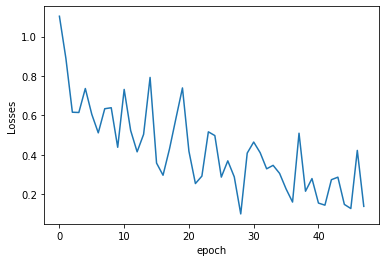

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_data_loader)), allLosses)
plt.ylabel('Losses')
plt.xlabel('epoch')

# ##########################################################################                                          train  model


In [16]:
train_accuracy = []
train_loss = []

for epoch in range(4):  # repeat loop over the dataset multiple times
    
    print(f"Running epoch... {epoch + 1 }")
    
    corr = 0
    n_samples = 0
    count = 0
    running_loss_train = 0
    
    for images, labels in train_data_loader:

        score_pred = my_cnn(images)        
        loss = loss_function(score_pred, labels)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        
        ############# Accu ########################
        _, predictions = torch.max(score_pred, 1)
        good_pred = (predictions == labels).sum().item()
        corr += good_pred
        n_samples += labels.size(0)
  
        count += 1
        
        ########### be carefull when u r appending the loss [after some iter or after an epoch !]
        if count % 15 == 0  : 
            running_loss_train += loss.item()
            train_accuracy.append(100 * corr / n_samples)
            print('[Epoch: {}. loss: {}. count: {}]'.format(epoch, loss.item(), count))
   
    epoch_loss_train = running_loss_train / len(train_data_loader) ### getting the avarage loss error of every epoch  
    train_loss.append(epoch_loss_train)
    
    print(f" --->> Accuracy on Training-data -->> : {100 * corr / n_samples}")
    

Running epoch... 1
[Epoch: 0. loss: 0.12015659362077713. count: 15]
[Epoch: 0. loss: 0.048307809978723526. count: 30]
[Epoch: 0. loss: 0.08701492846012115. count: 45]
 --->> Accuracy on Training-data -->> : 93.62549800796813
Running epoch... 2
[Epoch: 1. loss: 0.18209850788116455. count: 15]
[Epoch: 1. loss: 0.10167361795902252. count: 30]
[Epoch: 1. loss: 0.05062028765678406. count: 45]
 --->> Accuracy on Training-data -->> : 94.75431606905711
Running epoch... 3
[Epoch: 2. loss: 0.0343518927693367. count: 15]
[Epoch: 2. loss: 0.17558586597442627. count: 30]
[Epoch: 2. loss: 0.07051493972539902. count: 45]
 --->> Accuracy on Training-data -->> : 96.08233731739708
Running epoch... 4
[Epoch: 3. loss: 0.06478532403707504. count: 15]
[Epoch: 3. loss: 0.07208971679210663. count: 30]
[Epoch: 3. loss: 0.06230836734175682. count: 45]
 --->> Accuracy on Training-data -->> : 96.54714475431607


# ##########################################################################  Validatde  model

In [30]:
# Step 5: Validating the model using the val_data_loader set
val_loss = []
val_acc = []

with torch.no_grad():
    corr_pred = 0
    n_samples = 0
    running_val_loss = 0
    
    for x, y in val_data_loader:
        val_scores = my_cnn(x)
        valLoss = loss_function(val_scores, y)
        
        _, predictions = torch.max(val_scores, 1)
        goodPred = (predictions == y).sum().item()
        corr_pred += goodPred
        n_samples += y.size(0)

        val_acc.append(100 * corr_pred / n_samples)
        
       ############# loss error ########################
        running_val_loss += loss.item() 
    epoch_val_loss = running_val_loss / len(test_data_loader) ### getting the avarage loss error of every epoch
    val_loss.append(epoch_val_loss)

    print(f" >>> Accuracy ON test-data-loader >> : {100 * corr_pred / n_samples}")
    print(val_loss)

 >>> Accuracy ON test-data-loader >> : 96.74418604651163
[0.25636129453778267]


# ##########################################################################                                           Test model
Test the model

In [18]:
# Step 5: Test the model using the test_data_loader set
test_loss = []
test_acc = []

with torch.no_grad():
    
    corr_predTest = 0
    n_samplesTest = 0
    running_loss = 0
    
    for x, y in test_data_loader:
        test_scores = my_cnn(x)
        testLoss = loss_function(test_scores, y)
        test_loss.append(testLoss.item())
        
        _, predictions = torch.max(test_scores, 1)
        goodPredTest = (predictions == y).sum().item()
        corr_predTest += goodPredTest
        n_samplesTest += y.size(0)
        
        test_acc.append(100 * corr_predTest / n_samplesTest)

        ############# loss error ########################
        running_loss += loss.item() 
    epoch_loss = running_loss / len(test_data_loader) ### getting the avarage loss error of every epoch
    test_loss.append(epoch_loss)

    print(f" >>> Accuracy ON test-data-loader >> : {100 * corr_predTest / n_samplesTest}")
    print(test_loss)

 >>> Accuracy ON test-data-loader >> : 93.98148148148148
[0.07386868447065353, 0.11113063991069794, 0.23177658021450043, 0.04416002333164215, 0.14649216830730438]


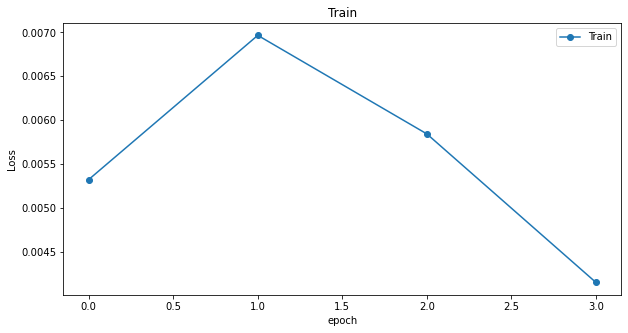

In [19]:
# acc plots
plt.figure(figsize=(10,5))

plt.plot(train_loss, '-o')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['Train'])
plt.title("Train")

plt.show()

# Train, Val, Test ----- Loss Error

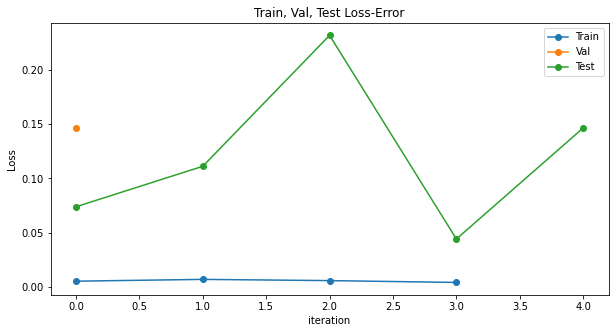

In [27]:
# acc plots
plt.figure(figsize=(10,5))

plt.plot(train_loss, '-o')
plt.plot(val_loss, '-o')
plt.plot(test_loss, '-o')

plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend(['Train','Val', 'Test'])

plt.title("Train, Val, Test Loss-Error")

plt.show()

# Train Accu

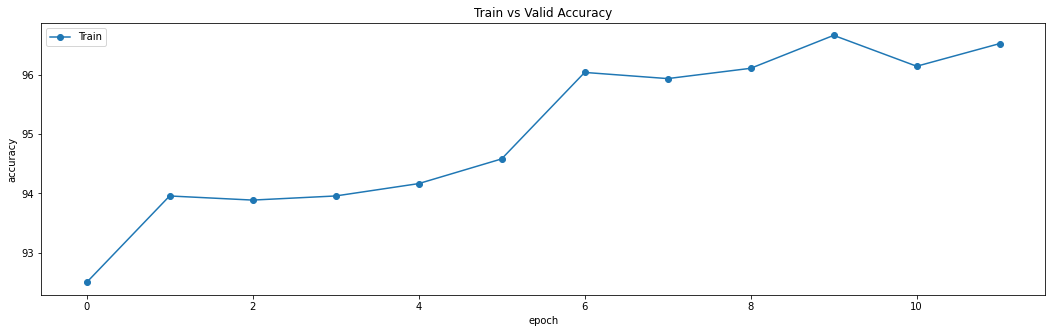

In [21]:
plt.figure(figsize=(18,5))

plt.title('Train vs Valid Accuracy')
plt.plot(train_accuracy,'-o')
# plt.plot(val_acc,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])

plt.show()

# Train, Val accuracy

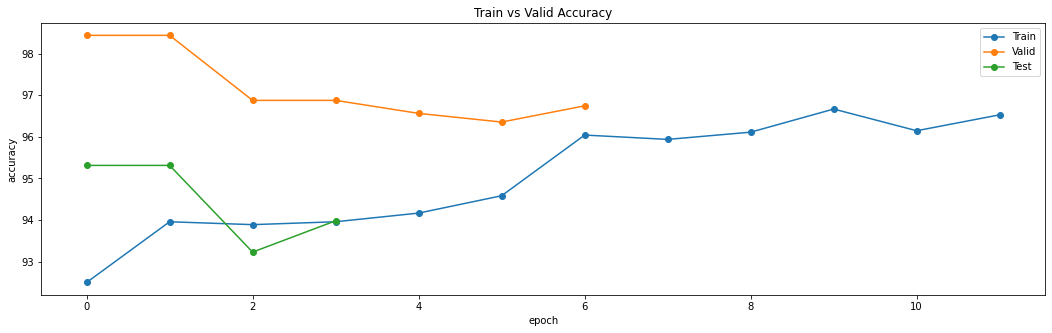

In [22]:
plt.figure(figsize=(18,5))

plt.title('Train vs Valid Accuracy')
plt.plot(train_accuracy,'-o')
plt.plot(val_acc,'-o')
plt.plot(test_acc,'-o')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid', 'Test'])

plt.show()

In [23]:
# meanwhile, here are a few things to know:
# 1. maintain good activity on GitHub, commit everyday
# 2. transfer your code to VS code and commit. Every day there should be a green block
# 3. Join the Slack channel and try to join some existing projects there. 
# Network with some people that already exist in the AI 

# Save model

In [24]:
# Specify a path
PATH = "my_cnn_entire_model.pt"

# Save
torch.save(my_cnn, PATH)

# Load
model = torch.load(PATH)
model.eval()

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc2): Linear(in_features=50176, out_features=3, bias=True)
)